- **Brocco Luca**         id: 2165810
- **Cavallin Jonathan**    id: 2159285
- **Cafagno Samuele**      id: 2159164
- **Di Lucia Sofia**       id: 2149752



## 1)

First we install keras-tuner and suppress output

In [20]:
!pip install keras-tuner #&>/dev/null

In [21]:
!pip install tensorflow.keras

Then we import basic libraries and set basic quantities for this learning task

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner as kt
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from IPython.display import clear_output
from sklearn.model_selection import KFold


# default font
plt.rcParams['font.size'] = 13

# number of data points, i.e., database size
N=2000
# size of each sample
L=8
# box size
B=10


%run useful.py

## 1.1) Creation of the dataset
Here we create the dataset and we plot it

2 5 1


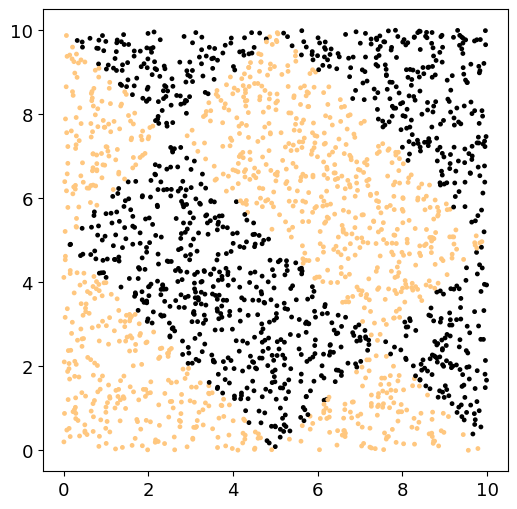

./DATA/data-for-DNN_type3_L8.dat
./DATA/labels-for-DNN_type3_L8.dat


In [23]:
TYPE=3

# random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

x,y = (np.random.random((N,L)))*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = NF(x[i],B,TYPE)

plot_data(x,y)

fn=filename("data",L,TYPE)
np.savetxt(fn,x)
print(fn)
fn=filename("labels",L,TYPE)
np.savetxt(fn,y,fmt="%d")
print(fn)

# 2) Data preparation

In [24]:
# default font
plt.rcParams['font.size'] = 13

%run useful.py

# training data
perc_train = 0.7
perc_test = 0.15
perc_valid = 0.15
TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
N = len(x)
# compute average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])

# number of samples in each set
N_train = int(perc_train * N)
N_test = int(perc_test * N)
N_valid = int(perc_valid * N)


## 2.1) Normalize data

We rescale the Dataset to have $\mu=0$ and $\sigma=1$

In [25]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
   
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## 2.2) Split data into training, validation and test set

We used 70% of samples as training set, 15% for both validation and test set.

In [26]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:N_train+N_valid],y[N_train:N_train+N_valid])
(x_test, y_test) = (x[N_train+N_valid:],y[N_train+N_valid:])

x_train_backup = x_train.copy()
y_train_backup = y_train.copy()

print("Train:",len(x_train),"points","\t Validation:",len(x_valid),"points","\t Test:",len(x_test),"points\n")

print(f"Train set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_train[y_train == 1])/len(x_train)*100,2)}% \t {round(len(x_train[y_train == 0])/len(x_train)*100,2)}%\n")
print(f"Valid set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_valid[y_valid == 1])/len(x_valid)*100,2)}% \t {round(len(x_valid[y_valid == 0])/len(x_valid)*100,2)}%\n")
print(f"Test set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_test[y_test == 1])/len(x_test)*100,2)}% \t {round(len(x_test[y_test == 0])/len(x_test)*100,2)}%\n")


Train: 1400 points 	 Validation: 300 points 	 Test: 300 points

Train set fraction of datapoints:
ones 	 zeros
49.71% 	 50.29%

Valid set fraction of datapoints:
ones 	 zeros
49.67% 	 50.33%

Test set fraction of datapoints:
ones 	 zeros
48.0% 	 52.0%



## 2.3) Define model with Keras

Here we define the function that builds the DNN model with different hyperparameters.

The options for the hyperparameters are:
- **Activation function:** ReLu, Tanh, Sigmoid and ELU
- **Minimizer:** Adam, RMSprop and Nesterov
- **Learning rate:** $10^{-6}$, $10^{-5}$, $10^{-4}$, $10^{-3}$, $10^{-2}$, $10^{-1}$
- **Dropout rate:** 0, 0.1, 0.2, 0.3


In [27]:
import warnings
warnings.filterwarnings('ignore')

def build_model(hp):
    model = Sequential()
    n_hidden_layers = 3

    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))

    # hidden layers
    for i in range(n_hidden_layers):
        model.add(
            Dense(
            20, # num of neurons
            activation = hp.Choice(f"activation_{i}",['relu','tanh','sigmoid','elu'])
            )
        )
        model.add(
            Dropout(
                rate = hp.Float(f"dropout_rate_{i}",min_value=0,max_value=0.3,step=0.1)
            )
        )

    # output layer
    model.add(Dense(1,activation='sigmoid'))

    # choice of optimizer
    optimizer_choice = hp.Choice("optimizer", ['Adam', 'RMSprop', 'Nesterov'])

    # choice of exponent of LR
    exponent_choice = hp.Choice('lr_exponent',[-1,-2,-3,-4,-5,-6])

    # each optimizer has to have a learning rate well-defined
    if optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate = 10 ** exponent_choice
        )
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(
            learning_rate = 10 ** exponent_choice
        )
    else:
        optimizer = SGD(
            learning_rate = 10 ** exponent_choice,
            #momentum=hp.Float("momentum", min_value=0.0, max_value=1.0),
            nesterov=True
        )

    # compilation of the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

trial = build_model(kt.HyperParameters())
# print a summary of the model
trial.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

## 2.4) Hyperparameters selection

Here we setup the tuner for the **Random Search**; _max_trials_ is the number of combinations of hyperparameters to try and we use 400 epochs for each trial.

In [28]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 24, # parameters permutations are 240
    executions_per_trial = 1,
)


Reloading Tuner from ./untitled_project/tuner0.json


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop', 'Nesterov'], 'ordered': False}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1

In [30]:
nepoch = 400
tuner.search(x_train,y_train,epochs=nepoch,validation_data=(x_valid,y_valid))

We print the validation accuracy for the different trial, sorted from the best to the worst. Then we select the best models, with an accuracy within 0.1 from the best result.

In [31]:
trials = tuner.oracle.trials

results = []
for trial_id, trial in trials.items():
    if "val_accuracy" in trial.metrics.metrics:
        best_val_acc = trial.metrics.metrics["val_accuracy"].get_best_value()
        results.append({
            "trial_id": trial_id,
            "best_val_accuracy": best_val_acc,
            "hyperparameters": trial.hyperparameters.values
        })

df_results = pd.DataFrame(results)
df_results_print = df_results[["trial_id","best_val_accuracy"]]

print(df_results_print.sort_values(by="best_val_accuracy", ascending=False))

   trial_id  best_val_accuracy
11       16             0.9850
13       15             0.9825
16       22             0.9775
17       01             0.9650
3        09             0.7900
20       19             0.7800
7        04             0.6575
4        23             0.6475
1        08             0.6025
2        14             0.5925
19       11             0.5850
22       02             0.5675
18       07             0.5675
12       03             0.5650
10       17             0.5650
6        10             0.5600
0        20             0.5550
21       05             0.5300
5        21             0.5300
23       18             0.5300
14       12             0.5250
15       00             0.5100
9        06             0.4900
8        13             0.4850


In [32]:
thresh = max(df_results["best_val_accuracy"]) - 0.1

selected_results = df_results[df_results["best_val_accuracy"] > thresh]
#print(selected_results['trial_id'])
print('selected models:',len(selected_results))
selected_trial_ids = set(selected_results["trial_id"].tolist())

candidate_models = [entry for entry in results if entry['trial_id'] in selected_trial_ids]
#print(f'\n {candidate_models}')
print('selected models ids:',[entry["trial_id"] for entry in candidate_models])

selected models: 4
selected models ids: ['16', '15', '22', '01']


## 2.3.1) K-fold cross validation

We perform a 5-fold cross validation between the selected models.

In [33]:
def create_model(hyperparams): #### function to define the previously selected models without rerunning the random search
    model = keras.Sequential()

    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))

    # First layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_0']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_0']))

    # Second layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_1']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_1']))

    # Third layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_2']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_2']))

    # Output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))


    if hyperparams["optimizer"] == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = hyperparams["learning_rate"])
    elif hyperparams["optimizer"] == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate = hyperparams["learning_rate"])
    elif hyperparams["optimizer"] == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = hyperparams["learning_rate"]) 
    elif hyperparams["optimizer"] == "Nesterov":
        optimizer = keras.optimizers.SGD(learning_rate = hyperparams["learning_rate"])
    else:
        raise ValueError("Unsupported optimizer!")

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model



In [34]:

k = 5 # number of folds
kfold_nepoch = 400 # number of epoch per each kfold training step
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

# redefining all dataset (Train set + Validation set) to be used for KFold
(x_KF, y_KF) = (x[0:N_train+N_valid],y[0:N_train+N_valid])
print("KFold dataset:",len(x_KF),"points\n")

fold_accuracies = [] # store results

for model in candidate_models:
    hyperparams = model["hyperparameters"]
    tbt_model = create_model(hyperparams)

    start_kfold_time = time.time()
    for train_index, val_index in kf.split(x_KF):
        x_train, x_val = x_KF[train_index], x_KF[val_index]
        y_train, y_val = y_KF[train_index], y_KF[val_index]

        tbt_model.fit(x_train, y_train, epochs = kfold_nepoch, batch_size = 32, verbose = 0)

        val_loss, val_acc = tbt_model.evaluate(x_val, y_val, verbose = 0)
        fold_accuracies.append(val_acc)
        print(f"Fold {len(fold_accuracies)} accuracy: {val_acc:.4f}")


    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    model["k_fold_val_acc"] = mean_acc
    model["k_fold_val_acc_error"] = std_acc


    time.sleep(5)
    clear_output()

    fold_accuracies = []
clear_output()
print(f"Training complete! Trained {len(candidate_models)} models")

Training complete! Trained 4 models


We choose the model with lowest average validation error as the best and train it on the whole training and validation set and we test it on the test set.

In [35]:
max_acc = 0
best_model = None

for model in candidate_models:
    if model['k_fold_val_acc'] > max_acc:
        max_acc = model['k_fold_val_acc']
        best_model = model

print(f"best model according to k-fold is model index {best_model['trial_id']}")
print(f"accuracy: {round(best_model['k_fold_val_acc'],3)} +- {round(best_model['k_fold_val_acc_error'],3)}")
print(f"params:")
print(best_model["hyperparameters"])


best model according to k-fold is model index 22
accuracy: 0.966 +- 0.018
params:
{'activation_0': 'elu', 'dropout_rate_0': 0.2, 'activation_1': 'elu', 'dropout_rate_1': 0.1, 'activation_2': 'elu', 'dropout_rate_2': 0.1, 'optimizer': 'RMSprop', 'learning_rate': 0.0020352446986152835, 'momentum': 0.22223463919726105}


In [36]:
final_model = create_model(best_model['hyperparameters'])
final_model.fit(x_KF,y_KF,epochs = nepoch, batch_size = 32, verbose = 0)
final_loss, final_acc = final_model.evaluate(x_test, y_test)
print(final_model)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.0709  
<Sequential name=sequential_9, built=True>


## 3) Data reduction and augmentation

We defined functions for data reduction and augmentation, considering different percentages (20%, 40%, 60%, 80%) for both reducing and augmenting the dataset. In particular, to perform data augmentation we introduced a multi-dimensional gaussian noise for each point, with standard deviation euqal to a percentage of the standard deviation of the original training set in each dimension. We assign as labels for the new points the same label of the point used to create each of them (we basically assume that since the gaussian noise is small and the new points will not be further misplaced from the original points, also the label will not change most of the times).
Then we train the best model using the augmented and reduced dataset and analyse how the test accuracy changes.

In [37]:
x_train = x_train_backup
y_train = y_train_backup
print(np.shape(x_train),np.shape(y_train))


(1400, 8) (1400,)


In [38]:
def reduce_data(x_train, y_train, fraction):
    n_samples = int(len(x_train) * fraction)
    indices = np.random.choice(len(x_train), n_samples, replace=False)
    return x_train[indices], y_train[indices]

k = 5
perc = [0.8, 0.6, 0.4, 0.2]  # different percentages used to reduced the training dataset 
accuracies = []
err_accuracies = []
temp = []
for p in perc:
    for i in range(k):
        x_train_red, y_train_red = reduce_data(x_train, y_train, p)        
        model = final_model
        model.fit(x_train_red, y_train_red, epochs=nepoch, batch_size=32, verbose=0)
        loss, acc = model.evaluate(x_test, y_test, verbose = 0)
        temp.append(acc)
    avg_acc = np.mean(temp)
    err_acc = np.std(temp)
    accuracies.append(avg_acc)
    err_accuracies.append(err_acc)
    temp = []
    print(f"With {int(p*100)}% of training data: accuracy = {round(avg_acc, 3)} +- {round(err_acc,3)}")#, loss = {round(loss, 3)}")   # perché diverso dall'output


With 80% of training data: accuracy = 0.967 +- 0.009
With 60% of training data: accuracy = 0.966 +- 0.006
With 40% of training data: accuracy = 0.942 +- 0.013
With 20% of training data: accuracy = 0.921 +- 0.014


In [39]:
# Data augmentation

noise_level = 0.05   

def add_noise(data,cov,noise_level):
    total_noise=[]
    for point in data:
        noise = np.random.multivariate_normal(point,cov*noise_level)
        total_noise.append(noise)
    return np.array(total_noise)

cov = np.zeros((L,L))

for i in range(L):
    std= x_train.std(axis=0)
    cov[i,i]= (std[i])**2
size_new_data = perc 

aug_accuracies = []
aug_errors = []
temp = []

for size in size_new_data:
    for j in range(k):
        
        new_x_data, new_y_data = reduce_data(x_train, y_train, size)
        x_train_aug = np.vstack( (x_train, add_noise(new_x_data,cov,noise_level)) )
        y_train_aug = np.hstack((y_train, new_y_data)) # the new data have the same label of the original data we used to define them
        if j == 0:
            print(f"New Training Set Size: {len(x_train_aug)}")
    
        aug_model = final_model
        aug_model.fit(x_train_aug, y_train_aug, epochs=nepoch, batch_size=32, verbose=0)
        aug_loss, aug_acc = aug_model.evaluate(x_test, y_test,verbose=0)
        temp.append(aug_acc)
    avg_acc = np.mean(temp)
    err_acc = np.std(temp)
    temp = []
    aug_accuracies.append(aug_acc)
    aug_errors.append(err_acc)
    print(f"Augmented Data Accuracy: {round(avg_acc, 3)} +- {round(err_acc,3)}")

New Training Set Size: 2520
Augmented Data Accuracy: 0.939 +- 0.009
New Training Set Size: 2240
Augmented Data Accuracy: 0.96 +- 0.01
New Training Set Size: 1960
Augmented Data Accuracy: 0.948 +- 0.014
New Training Set Size: 1680
Augmented Data Accuracy: 0.957 +- 0.009


We plot the results and the accuracy performance on the test set in both cases. 

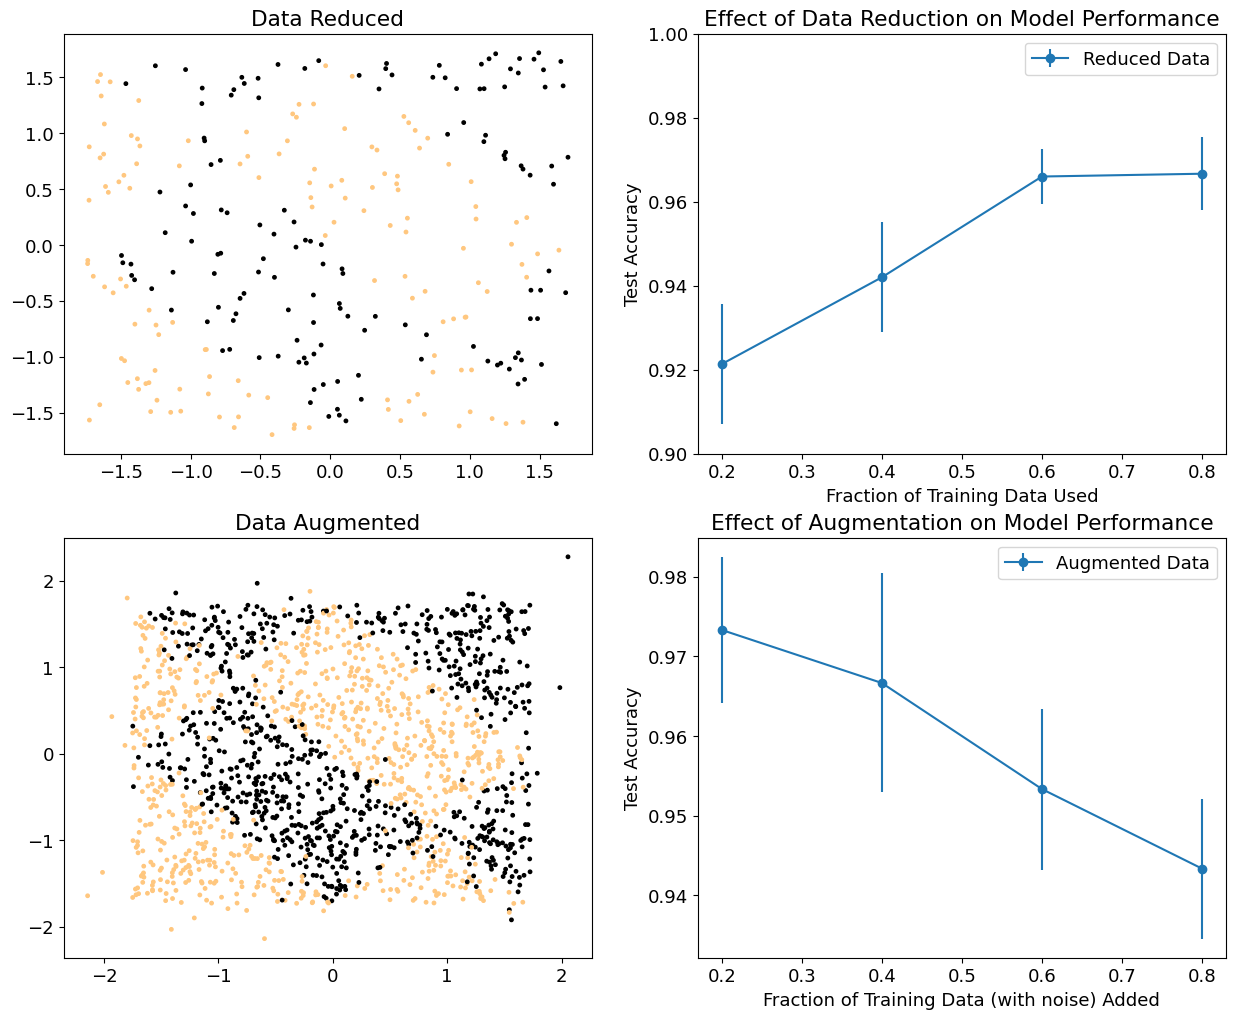

In [40]:
fig, AX = plt.subplots(2, 2, figsize=(15,12))
ax = AX[0,0]
ax.scatter(x_train_red[:,0],x_train_red[:,1],c=y_train_red[:len(x_train_red)],s=6)
ax.set_title("Data Reduced")
ax = AX[0, 1]
ax.errorbar(perc, accuracies,yerr=err_accuracies, marker='o', label='Reduced Data')
ax.set_ylim([0.9,1])
ax.set_xlabel("Fraction of Training Data Used")
ax.set_title("Effect of Data Reduction on Model Performance")
ax.set_ylabel("Test Accuracy")
ax.legend()

ax = AX[1,0]
ax.scatter(x_train_aug[:,0],x_train_aug[:,1],c=y_train_aug[:len(x_train_aug)],s=6)
ax.set_title("Data Augmented")
ax=AX[1, 1]
ax.errorbar(size_new_data, aug_accuracies,yerr=aug_errors, marker='o', label='Augmented Data')
ax.set_xlabel("Fraction of Training Data (with noise) Added")
ax.set_ylabel("Test Accuracy")
ax.set_title("Effect of Augmentation on Model Performance")
ax.legend()

plt.show()

As expected, for the reduction the accuracy is compatible with the one from the original dataset and there is no significant deviation for the different fractions considered. This is because we are reusing parts of the original dataset used for hyperparameters tuning. 
On the other hand, augmenting the data causes a gradual decrease in the accuracy, since the previous best model is tuned on different data.